In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker

In [156]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
    'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(
        x=x, sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(
                    x=x, sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    return df_gr
    

In [159]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['FIPS','date','Total_deaths','Daily_deaths']]
df_covid = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['FIPS', 'date'])
df_covid

,FIPS,COUNTY,STATE,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths
0,01001,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,0.0,0,0.0
1,01003,Baldwin,Alabama,30.727750,-87.722071,2020-01-22,0,0.0,0,0.0
2,01005,Barbour,Alabama,31.868263,-85.387129,2020-01-22,0,0.0,0,0.0
3,01007,Bibb,Alabama,32.996421,-87.125115,2020-01-22,0,0.0,0,0.0
4,01009,Blount,Alabama,33.982109,-86.567906,2020-01-22,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
565555,56037,Sweetwater,Wyoming,41.659439,-108.882788,2020-07-19,173,2.0,0,0.0
565556,56039,Teton,Wyoming,43.935225,-110.589080,2020-07-19,208,11.0,0,0.0
565557,56041,Uinta,Wyoming,41.287818,-110.547578,2020-07-19,221,0.0,0,0.0
565558,56043,Washakie,Wyoming,43.904516,-107.680187,2020-07-19,44,1.0,0,0.0


In [160]:
def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    
    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

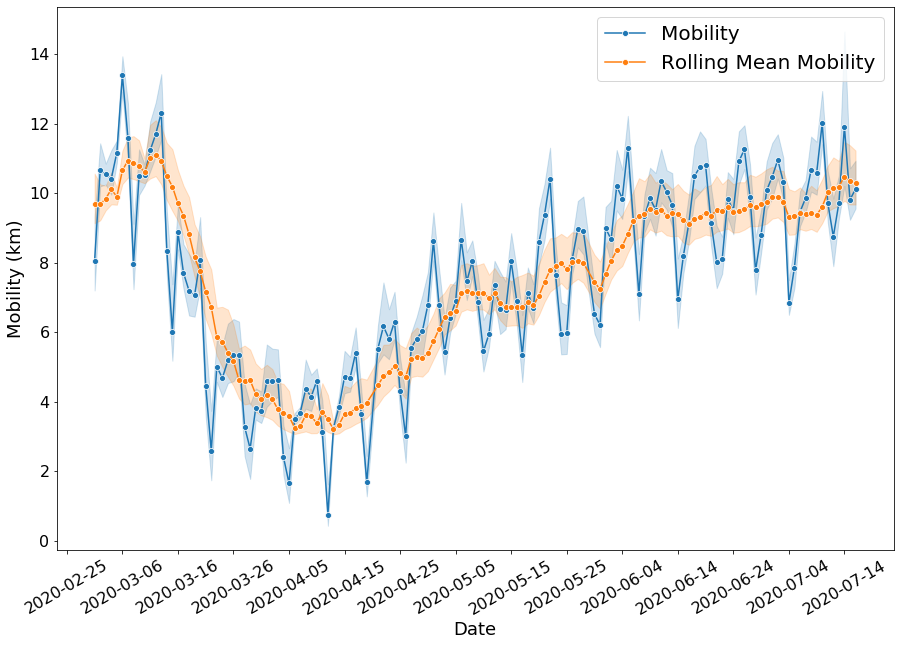

In [165]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y = 'm50', data=df_mobility_index, marker='o',ci=99,label = 'Mobility')
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='o',ci=99, label = 'Rolling Mean Mobility')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Mobility (km)', fontsize = 18)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)
plt.legend(fontsize = 20)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

In [166]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker
county_spending_url =  'https://raw.githubusercontent.com/Opportunitylab/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'
df_county_spending = pd.read_csv(county_spending_url)

df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                            df_county_spending['month'].astype(str) + '-' + \
                            df_county_spending['day'].astype(str)
df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
df_county_spending

,year,month,day,fips,spend_all,date
0,2020,1,24,01001,0.17700,2020-01-24
1,2020,1,24,01003,0.06100,2020-01-24
2,2020,1,24,01009,0.00878,2020-01-24
3,2020,1,24,01015,-0.01960,2020-01-24
4,2020,1,24,01021,0.09500,2020-01-24
...,...,...,...,...,...,...
248324,2020,7,8,56037,0.01380,2020-07-08
248325,2020,7,8,56039,0.22600,2020-07-08
248326,2020,7,8,56041,-0.06790,2020-07-08
248327,2020,7,8,56043,0.02100,2020-07-08


In [5]:
# Importing County Level Unemployment Insurance claims data from https://github.com/Opportunitylab/EconomicTracker

ui_url = 'https://raw.githubusercontent.com/Opportunitylab/EconomicTracker/main/data/UI%20Claims%20-%20County%20-%20Weekly.csv'
df_ui = pd.read_csv(ui_url)
df_ui['date'] = df_ui['year'].astype(str) + '-' + \
                df_ui['month'].astype(str) + '-' + \
                df_ui['day_endofweek'].astype(str)
df_ui.date = pd.to_datetime(df_ui.date, infer_datetime_format=True)
df_ui.initial_claims_rate = '0' + df_ui.initial_claims_rate.astype(str)
df_ui.initial_claims_rate = 3 - df_ui.initial_claims_rate.astype(float)
df_ui.countyfips = df_ui.countyfips.astype(str).str.zfill(5)
df_ui


,year,month,day_endofweek,countyfips,initial_claims,initial_claims_rate,date
0,2020,1,11,06001,1624,2.808,2020-01-11
1,2020,1,11,06003,3.03,2.450,2020-01-11
2,2020,1,11,06005,56.6,2.620,2020-01-11
3,2020,1,11,06007,439,2.558,2020-01-11
4,2020,1,11,06009,80.6,2.624,2020-01-11
...,...,...,...,...,...,...,...
31466,2020,7,4,55133,1642,2.269,2020-07-04
31467,2020,7,4,55135,362,1.600,2020-07-04
31468,2020,7,4,55137,115,1.990,2020-07-04
31469,2020,7,4,55139,834,2.088,2020-07-04


In [6]:
# Taking the rolling mean ~ 7 days by each county
mob_col= ['m50']
m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
m50 = m50.reset_index()
m50

,fips,date,m50,rolling_mean_mob
0,01001,2020-03-01,7.194,7.194000
1,01001,2020-03-02,14.587,10.890500
2,01001,2020-03-03,13.865,11.882000
3,01001,2020-03-04,13.880,12.381500
4,01001,2020-03-05,14.659,12.837000
...,...,...,...,...
360062,56041,2020-07-12,24.010,11.900000
360063,56041,2020-07-13,5.584,11.827143
360064,56041,2020-07-14,5.035,11.497429
360065,56041,2020-07-15,6.373,11.477571


(737485.0, 737622.0)

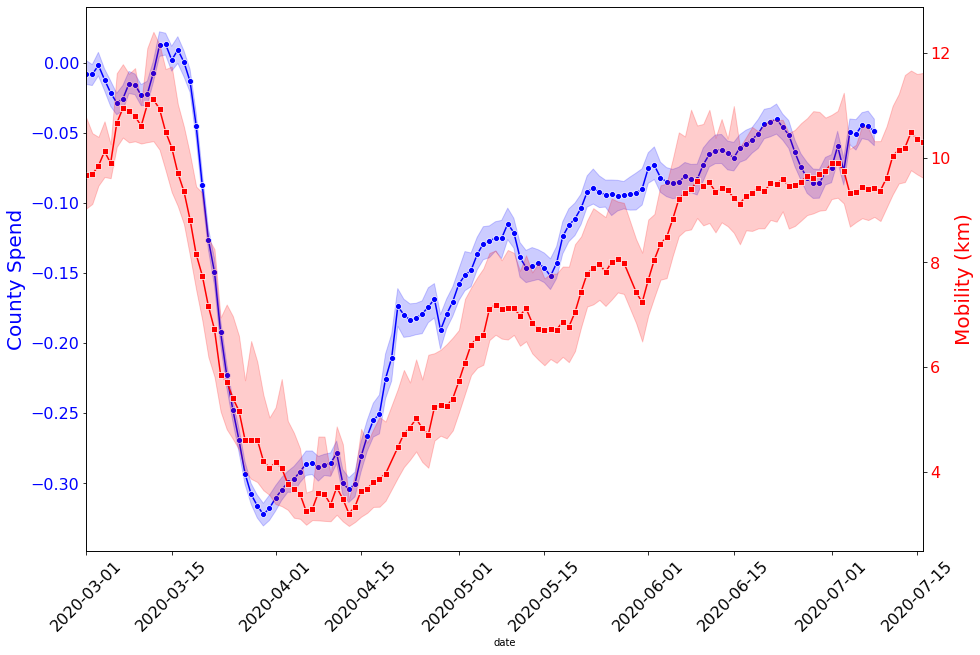

In [15]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(x='date', y = 'spend_all', data=df_county_spending, marker='o',ci=100,color='blue')
plt.ylabel('County Spend', color='blue', fontsize=20)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16,color='blue')
ax2 = ax.twinx()
sns.lineplot(x='date', y = 'rolling_mean_mob', data=m50, marker='s',ci=100, ax =ax2, color = 'red')
plt.ylabel('Mobility (km)',color='red', fontsize=20)
plt.yticks(fontsize=16,color='red')
plt.xlim(m50.date.min(), m50.date.max())

In [8]:
# Merging the mobility and spend dataset
df_merged = pd.merge(left = m50, right = df_county_spending, on = ['fips', 'date'], how = 'outer')
df_merged

,fips,date,m50,rolling_mean_mob,year,month,day,spend_all
0,01001,2020-03-01,7.194,7.1940,2020.0,3.0,1.0,0.038700
1,01001,2020-03-02,14.587,10.8905,2020.0,3.0,2.0,0.062400
2,01001,2020-03-03,13.865,11.8820,2020.0,3.0,3.0,-0.000954
3,01001,2020-03-04,13.880,12.3815,2020.0,3.0,4.0,-0.019600
4,01001,2020-03-05,14.659,12.8370,2020.0,3.0,5.0,-0.019000
...,...,...,...,...,...,...,...,...
423353,46115,2020-07-08,NaN,NaN,2020.0,7.0,8.0,0.201000
423354,48023,2020-07-08,NaN,NaN,2020.0,7.0,8.0,-0.173000
423355,56011,2020-07-08,NaN,NaN,2020.0,7.0,8.0,0.373000
423356,56043,2020-07-08,NaN,NaN,2020.0,7.0,8.0,0.021000


In [14]:
# Creating a dataframe containing county spending and mobility Pearson correlation coefficient
def get_county_state(val_dict,x):
    return val_dict[x]

df_county_geocodes = pd.read_csv('./Data/County_GEOCODES-v2017.csv',encoding='latin')
df_county_geocodes['fips'] = df_county_geocodes['fips'].astype(str).str.zfill(5)
county_dict = df_county_geocodes.set_index('fips')['long_name'].to_dict()
# Pearson correlation between consumer spending and mobility
df_mobility_spend_corr = df_merged.groupby(['fips'])[['m50','spend_all']].corr().reset_index()
df_mobility_spend_corr = df_mobility_spend_corr[df_mobility_spend_corr['level_1']=='m50']
df_mobility_spend_corr = df_mobility_spend_corr.drop(columns=['level_1', 'm50'])
df_mobility_spend_corr = df_mobility_spend_corr.rename(columns={'spend_all':'Mob-Spend Corr'})

df_mobility_spend_corr['loc'] = df_mobility_spend_corr['fips'].apply(lambda x: get_county_state(county_dict,x))
df_mobility_spend_corr['Mob-Spend Corr'] = df_mobility_spend_corr['Mob-Spend Corr'].round(2)
df_mobility_spend_corr

,fips,Mob-Spend Corr,loc
0,01001,0.57,Autauga County AL
2,01003,0.77,Baldwin County AL
4,01005,NaN,Barbour County AL
6,01007,NaN,Bibb County AL
8,01009,0.39,Blount County AL
...,...,...,...
5406,56037,0.32,Sweetwater County WY
5408,56039,0.82,Teton County WY
5410,56041,0.16,Uinta County WY
5412,56043,NaN,Washakie County WY


In [10]:
# Creating functions to create map/json and color scales
def generate_geojson_map(df,col_name,tooltip_col=None,name=None):
    df = df.rename(columns={'fips':'GEO_ID'})
    mdict = df.set_index('GEO_ID')[col_name].to_dict()
    fpath = create_geo_json(df,col_name)
    with open(fpath,encoding="utf-8") as json_file:
         county_geo = json.load(json_file)
    gmap = folium.GeoJson(
        data = county_geo,name=name,
        tooltip=folium.GeoJsonTooltip(fields=[tooltip_col,col_name]),
        style_function = lambda feature: {
            'fillColor': get_color(mdict,feature),
            'fillOpacity': 0.7,
            'color' : 'black',
            'weight' : 0.1,
        }    
    )
    color=plt.get_cmap("plasma")

    min_color = rgb2hex(color.colors[0][:3])
    mid_color = rgb2hex(color.colors[127][:3])
    max_color = rgb2hex(color.colors[-1][:3])
    color_scale = LinearColormap([min_color,mid_color,max_color],
                                 vmin =min(mdict.values()), 
                                 vmax=max(mdict.values()) )
    return gmap,color_scale

def filter_geo(geo_list,x):
    if x in geo_list:
        return x
    else:
        return None
def get_col_value(val_dict,x):
    return val_dict[x]
def create_geo_json(df,col_name):
    geo_list = df.GEO_ID.unique()
    df = df[[col_name,'GEO_ID','loc']]
    df_geo = gpd.read_file('./Data/geometry/county.geojson', driver='GeoJSON')
    val_dict = df.set_index('GEO_ID')[col_name].to_dict()
    df_geo['GEO_ID'] =  df_geo['GEO_ID'].astype(str).str[-5:]
    df_geo['GEO_ID'] =  df_geo['GEO_ID'].apply(lambda x: filter_geo(geo_list,x))
    df_geo = df_geo.dropna()
    df_geo = df_geo.join(df.set_index('GEO_ID'), on='GEO_ID', how='inner')
    df_geo = df_geo.dropna()
    fpath = './Data/geometry/County_Geo_' + col_name + '.json'
    df_geo.to_file(fpath,driver='GeoJSON')
    return (fpath)

def get_color(map_dict,feature):
    color=plt.get_cmap("plasma")
    min_val = min(map_dict.values())
    max_val = max(map_dict.values())
    color_sc = 255/(abs(min_val) + abs(max_val))
    value = int((map_dict.get(feature['properties']['GEO_ID'])+ abs(min_val))*color_sc)
    rgb = color.colors[value][:3]
    return str((matplotlib.colors.rgb2hex(rgb)))

In [11]:
# Map showing Linear Correlation between Consumer Spending and Mobility on County Level
us_cen = [39.8283,-98.5795]
base_map = folium.Map(location=us_cen,zoom_start=4)
gmap,color_scale = generate_geojson_map(df_mobility_spend_corr,'Mob-Spend Corr',
                                        name='Spend-Mobility Pearson Correlation', tooltip_col='loc')
base_map.add_child(gmap)
base_map.add_child(folium.map.LayerControl())
base_map.add_child(color_scale)
output_path= './data/output'
os.makedirs(output_path,exist_ok=True)
base_map.save('./data/output/Mobility_Spend_Corr.html')
base_map

In [22]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob','spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_covid = df_merged[df_merged.date>=window]
df_pre = df_merged[(df_merged.date<window)]
df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_covid.groupby(['fips','date'])[target_cols].mean()


post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = y.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

,fips,rolling_mean_mob,spend_all,Min_rolling_mean_mob,Min_spend_all,min_date_rolling_mean_mob,min_date_spend_all,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob,Drop_days_spend_all,Norm_Drop_Rate_spend_all,Pct_Red_spend_all
581,17117,8.280643,-0.039400,1.800571,-0.318,2020-03-28,2020-03-28,13.0,0.060197,0.782557,13.0,0.024462,0.318
60,01121,17.630429,-0.032879,4.720857,-0.236,2020-04-12,2020-03-29,28.0,0.026151,0.732232,14.0,0.016857,0.236
284,12023,6.964750,-0.032875,3.889286,-0.273,2020-04-19,2020-03-30,35.0,0.012616,0.441576,15.0,0.018200,0.273
89,04025,3.376964,0.015122,0.752714,-0.314,2020-04-13,2020-04-13,29.0,0.026797,0.777103,29.0,0.010828,0.314
326,12107,8.237857,-0.032957,3.531143,-0.194,2020-04-10,2020-03-29,26.0,0.021975,0.571352,14.0,0.013857,0.194


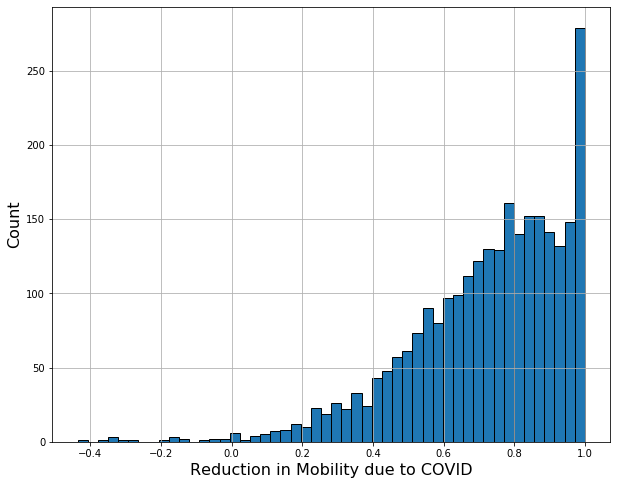

In [21]:
plt.figure(figsize=(10,8))
plt.rcParams["patch.force_edgecolor"] = True

df_mob_spend_red['Pct_Red_rolling_mean_mob'].hist(bins = 50)
plt.xlabel('Reduction in Mobility due to COVID', fontsize=16)
plt.ylabel('Count', fontsize = 16)
df_mob_spend_red['loc'] = df_mob_spend_red['fips'].apply(lambda x: get_county_state(county_dict,x))

In [31]:
# Get API keys from config file
def get_weather_chunk(lat,lng,start_dt, end_dt):
    url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'
    query = '?q=' + str(lat) + ','+str(lng)
    key = '&key=' + API_KEY
    ret_format = '&format=json'
    sdate = '&enddate='+ start_dt
    edate = '&date=' + end_dt
    tp = '&tp=24'
    final_url = url + query + ret_format +  edate + sdate + tp + key
    get_weather = requests.get(final_url)
    weather_data = json.loads(get_weather.text)
    df = pd.DataFrame(weather_data['data']['weather'])
    return df

def get_weather_data(lat,lng, start_date,end_date,county,state):
    new_low = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    new_end = datetime.timedelta(days=34) + new_low
    final_end = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    df = pd.DataFrame()
    
    last=False
    while(last==False):
        if new_end <final_end:
            
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            
            df_weather_chunk = get_weather_chunk(lat,lng,start_dt, end_dt)
            
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            new_low = new_end + datetime.timedelta(days=1)
            last_itr = new_end
            new_end = datetime.timedelta(days=34) + new_low

           
        else:
            new_low = last_itr + datetime.timedelta(days=1)
            new_end = final_end
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            df_weather_chunk = get_weather_chunk(lat,lng,start_dt, end_dt)
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            last = True

    df = df.drop(columns=['uvIndex'])
    df_h = pd.DataFrame()
    
    for val in df['hourly'].values:
        df_h = pd.concat([df_h, pd.DataFrame(val)], ignore_index=True)
    
    df = pd.concat([df, df_h], axis=1)
    use_cols = ['date','tempC', 'maxtempC', 'mintempC','WindChillC','FeelsLikeC', 'visibilityMiles','HeatIndexC', 
            'avgtempC', 'windspeedMiles', 'winddirDegree','pressure', 'WindGustMiles','precipMM',
            'totalSnow_cm' , 'sunHour', 'DewPointC','humidity','uvIndex']
    df = df[use_cols]
    cols= [col for col in df.columns if col!='date']
    df= df.apply(pd.to_numeric, errors='ignore')
    df.date = pd.to_datetime(df.date, infer_datetime_format=True)
    df['COUNTY'] = county
    df['STATE'] = state
    return df


In [47]:
df_mobility_index

,date,STATE,COUNTY,fips,samples,m50,m50_index
136,2020-03-01,Alabama,Autauga County,01001,1703,7.194,49
137,2020-03-02,Alabama,Autauga County,01001,1829,14.587,100
138,2020-03-03,Alabama,Autauga County,01001,1840,13.865,95
139,2020-03-04,Alabama,Autauga County,01001,1900,13.880,95
140,2020-03-05,Alabama,Autauga County,01001,1825,14.659,100
...,...,...,...,...,...,...,...
367134,2020-07-12,Wyoming,Uinta County,56041,756,24.010,766
367135,2020-07-13,Wyoming,Uinta County,56041,732,5.584,178
367136,2020-07-14,Wyoming,Uinta County,56041,651,5.035,160
367137,2020-07-15,Wyoming,Uinta County,56041,700,6.373,203


In [48]:
df_merged = pd.merge(left = df_mobility_index, right = df_covid_growth, on= ['COUNTY', 'STATE'],how='left')
df_merged['growthFactor'] = df_merged['growthFactor'].fillna(df_merged['growthFactor'].mean() )
df_merged.corr()

,samples,m50,m50_index,growthFactor
samples,1.000000,-0.069507,-0.045263,0.077986
m50,-0.069507,1.000000,0.279804,-0.014436
m50_index,-0.045263,0.279804,1.000000,-0.020126
growthFactor,0.077986,-0.014436,-0.020126,1.000000


In [37]:
start_date = datetime.datetime.strftime(df_merged.date.max(), '%Y-%m-%d')
end_date =  datetime.datetime.strftime(df_merged.date.min(), '%Y-%m-%d')

count_state = (pd.Series(zip(df_mobility_index.COUNTY, df_mobility_index.STATE)).unique())
fpath1 = './Data/Weather_Data/'
os.makedirs(fpath1, exist_ok=True)
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
counties_done = [(f.split('_')[3]+ ','+ f.split('_')[4]).split('.csv')[0] for f in weather_files]
for county,state in count_state[:1]:
    if county+','+state in counties_done:
        cnty_weat_file = fpath1 + 'Weather_Zip_'+str(county+'_'+state)+'.csv'
        df_county_weather = pd.read_csv(cnty_weat_file,parse_dates=['date'])
        if df_county_weather.date.max() == start_date:     
            continue
        else:
            end_date =  df_county_weather.date.max()
    lat,lng = df_merged[(df_merged['COUNTY']==county)&(df_merged['STATE']==state)][['Lat','Lng']].values[0]
    weather_df = get_weather_data(lat,lng, start_date,end_date,county,state)
    #weather_df.to_csv(fpath1 + 'Weather_Zip_'+str(county+'_'+state)+'.csv',index=False)

KeyError: 'COUNTY'

In [33]:
fpath1 = './Data/Weather_Data/'
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
zips_done = [f.split('_')[3].split('.csv')[0] for f in weather_files]

df_weather = pd.DataFrame()
for file in weather_files:
    df = pd.read_csv(file)
    df_weather = pd.concat([df_weather,df], ignore_index=True)
df_weather.date = pd.to_datetime(df_weather.date, infer_datetime_format=True)
df_weather.to_csv('./Data/All_County_State_Weather'+start_date+'.csv', index=False)
df_merged_weather = pd.merge(left = df_merged, right = df_weather, on =['date', 'STATE', 'COUNTY'])
df_merged_weather_covid = pd.merge(left = df_merged_weather, right = df_covid_us, on =['date', 'STATE', 'COUNTY'])
df_merged_weather_covid

KeyboardInterrupt: 

In [161]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,AJWBE001,AJWBE002,AJWBE003,AJWBE004,AJWBE005,AJWBE006,...,AJ35E059,AJ35E060,AJ35E061,AJ35E062,AJ35E063,AJ35E064,AJ35E065,AJ35E066,NAME_M,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,2,1310,1387,455,0,32,2458,0,"Autauga County, Alabama",0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,27,7046,8078,1462,4,760,9752,162,"Baldwin County, Alabama",0.4609


In [27]:
import re
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

NameError: name 'df_county_demo' is not defined

In [163]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo         

In [164]:
df_all = pd.merge(left = df_merged, right = df_county_demo, on = [ 'STATE', 'COUNTY'])
remove_cols = ['Min_Date','COUNTY', 'Pre_Covid_Mean_Mobility_Index', 
               'Post_Covid_Min_Mobility_Index','YEAR','NAME_E','Norm_Drop_Rate']
target_var = ['Visit_Reduction']
df_final = df_all.drop(columns=remove_cols)
df_final = df_final.dropna()
X =df_final.drop(columns=target_var)
y =df_final[target_var]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [165]:
X_train

,STATE,Drop_days,growthFactor,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,Sex by Age_Male 18 and 19 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_10.0 to 14.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001
2205,Kentucky,17,1.024478,8637,0.490680,0.028019,0.029293,0.034850,0.022577,0.017483,...,0.187852,0.077615,0.057368,0.039370,0.042745,0.109111,0.075366,0.146232,0.209224,0.4569
940,North Carolina,29,1.062903,130361,0.495348,0.038877,0.038171,0.038762,0.021072,0.013578,...,0.083765,0.129864,0.119495,0.112499,0.080705,0.049097,0.105628,0.185833,0.108189,0.4177
1815,Iowa,31,1.077123,25039,0.490754,0.029115,0.036303,0.039179,0.021606,0.013140,...,0.168367,0.131725,0.115955,0.114100,0.040816,0.038961,0.059369,0.103432,0.140538,0.3995
219,New York,30,1.027273,194402,0.491806,0.027093,0.029166,0.026363,0.018379,0.022273,...,0.089669,0.098801,0.091979,0.096784,0.072138,0.063300,0.071955,0.285070,0.082297,0.4591
445,North Carolina,22,1.023947,10813,0.473967,0.017294,0.031629,0.027189,0.009711,0.006936,...,0.117647,0.067109,0.167357,0.128418,0.019056,0.064623,0.004143,0.176471,0.226181,0.4871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,Georgia,25,1.070217,106497,0.475112,0.033747,0.039738,0.037316,0.025926,0.016498,...,0.075733,0.112078,0.094159,0.106584,0.081819,0.061702,0.090102,0.272082,0.057561,0.4384
1095,Idaho,17,1.010000,27969,0.511102,0.049233,0.051092,0.047088,0.030069,0.016483,...,0.129693,0.104664,0.233788,0.030717,0.035267,0.034130,0.036974,0.090444,0.153584,0.3723
1130,Kentucky,22,1.017534,22843,0.490303,0.031738,0.037473,0.024778,0.019700,0.010725,...,0.059140,0.069479,0.048801,0.102151,0.094706,0.083954,0.047560,0.188172,0.250620,0.4966
1294,New York,38,0.859362,26719,0.503425,0.029941,0.032000,0.034657,0.019574,0.010517,...,0.087283,0.089629,0.076959,0.083998,0.092445,0.054435,0.063820,0.265603,0.111685,0.4126


In [167]:
from sklearn.metrics import r2_score
import catboost
cat_index = [0]
cb_model = catboost.CatBoostRegressor(task_type='GPU', n_estimators=1000, eval_metric='RMSE',
                                      max_depth=6, learning_rate=0.05,verbose=200,cat_features=cat_index)
# lin_model = Ridge()
# lin_model.fit(X_train,y_train)
cb_model.fit(X_train,y_train)
#y_pred_lin = lin_model.predict(X_test)
y_pred_cb = cb_model.predict(X_test)

#print(r2_score(y_test,y_pred_lin))
print(r2_score(y_test,y_pred_cb))

0:	learn: 0.1987267	total: 41.8ms	remaining: 41.8s
200:	learn: 0.1030197	total: 6.09s	remaining: 24.2s
400:	learn: 0.0836300	total: 11.8s	remaining: 17.7s
600:	learn: 0.0730685	total: 17.5s	remaining: 11.6s
800:	learn: 0.0661193	total: 23.1s	remaining: 5.73s
999:	learn: 0.0614551	total: 28.5s	remaining: 0us
0.5624888110128731


In [168]:
df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=['Post_Covid_Feature_Importance'])
df_cb_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

,Post_Covid_Feature_Importance
STATE,17.742344
"Means of Transportation to Work_Car, truck, or van",3.791485
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,2.726305
"Means of Transportation to Work_Car, truck, or van Drove alone",2.424223
Race_Asian alone,1.790522
Means of Transportation to Work_Public transportation (excluding taxicab) Bus or trolley bus,1.618373
Race_Black or African American alone,1.578147
Drop_days,1.547376
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,1.495608
Sex by Age_Female 60 and 61 years,1.492326


In [194]:
import shap

from catboost import Pool
plt.rcParams['font.size'] = 12
plt.rc('xtick', labelsize=10)
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train),
                                               fstr_type="ShapValues",shap_calc_type='Approximate')
shap_values = shap_values[:, :-1]

title = "SHAP Value - CatBoost:COVID"
plt.title(title)
shap.summary_plot(shap_values, X_train, show=True)

TypeError: an integer is required (got type bytes)

In [46]:
top10_pop = df_all.groupby(['STATE'])['Sex by Age_Total'].mean().sort_values(ascending=False).index[:10]

def filter_df(x):
    if x in top10_pop:
        return x
    else:
        return None
df_all_fil = df_all.copy()

df_all_fil['STATE'] = df_all_fil['STATE'].apply(lambda x: filter_df(x))
df_all_fil = df_all_fil.dropna()


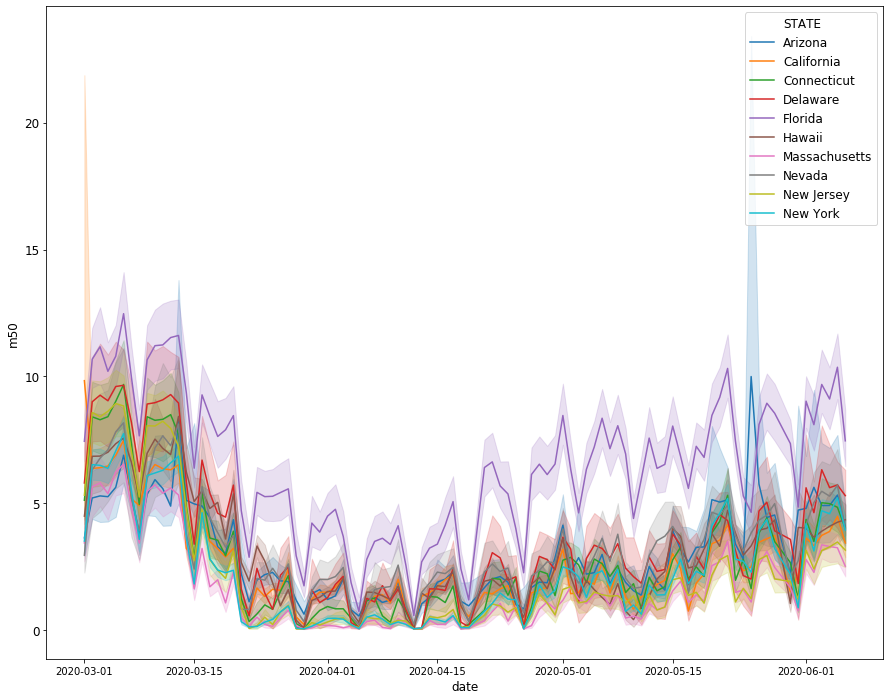

In [47]:
plt.figure(figsize=(15,12))
sns.lineplot(x='date', y = 'm50', hue='STATE', data=df_all_fil)